In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Gradient Boosting
import lightgbm as lgb
import xgboost as xgb

# Scikit-learn
from sklearn.metrics import average_precision_score
from sklearn.model_selection import StratifiedKFold 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Graphics
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset
from sklearn.datasets import load_boston

In [11]:
# Uploading the Boston dataset
X, y = load_boston(return_X_y=True)

# Transforming the problem into a classification (unbalanced)
y_bin = (y > np.percentile(y, 90)).astype(int)

In [13]:
#CRIM - per capita crime rate by town
#ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
#INDUS - proportion of non-retail business acres per town.
#CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
#NOX - nitric oxides concentration (parts per 10 million)
#RM - average number of rooms per dwelling
#AGE - proportion of owner-occupied units built prior to 1940
#DIS - weighted distances to five Boston employment centres
#RAD - index of accessibility to radial highways
#TAX - full-value property-tax rate per $10,000
#PTRATIO - pupil-teacher ratio by town
#B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
#LSTAT - % lower status of the population
#MEDV - Median value of owner-occupied homes in $1000's this is our target variable

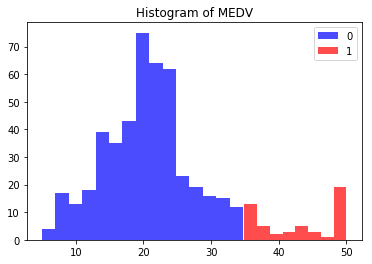

In [17]:
# Histogram highlighting the top 10% we use as a target
plt.hist(y[y <= np.percentile(y, 90)], bins='auto', alpha=0.7, label='0', color='b')
plt.hist(y[y > np.percentile(y, 90)], bins=8, alpha=0.7, label='1', color='r')
plt.title("Histogram of MEDV")
plt.legend(loc='upper right')
plt.show()

In [18]:
# For convenience, we will create a Pandas dataframe from X
train = pd.DataFrame(X)
train = train.add_prefix('var_')

In [20]:
# Checking about the shape of our training set
print(train.shape)

(506, 13)


In [21]:
# Setting a 5-fold stratified cross-validation (note: shuffle=True)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)

In [22]:
skf

StratifiedKFold(n_splits=5, random_state=8, shuffle=True)

In [23]:
MAX_ROUNDS = 2000
lgb_iter1 = []
sklearn_gbm_iter1 = []
xgb_gbm_iter1 = []

lgb_ap1 = []
sklearn_gbm_ap1 = []
xgb_gbm_ap1 = []

In [24]:
# Set up the classifier with standard configuration
# Later we will more performing parameters with Bayesian Optimization
params = {
    'learning_rate':  0.06, 
    'max_depth': 6, 
    #'lambda_l1': 16.7,
    'min_data_in_leaf':5,
    'boosting': 'gbdt', 
    'objective': 'binary', 
    'metric': 'auc',
    'feature_fraction': .9,
    'is_training_metric': False, 
    'seed': 1
}

In [25]:
for i, (train_index, test_index) in enumerate(skf.split(train,y_bin)):
    
    # Create data for this fold
    y_train, y_valid = y_bin[train_index], y_bin[test_index]
    X_train, X_valid = train.iloc[train_index,:], train.iloc[test_index,:]
        
    print( "\nFold ", i)

    # Running models for this fold
    
    # ->LightGBM
    lgb_gbm = lgb.train(params, 
                          lgb.Dataset(X_train, label=y_train), 
                          MAX_ROUNDS, 
                          lgb.Dataset(X_valid, label=y_valid), 
                          verbose_eval=False, 
                          #feval= auc, 
                          early_stopping_rounds=50)
    
    print( " Best iteration lgb = ", lgb_gbm.best_iteration)
    
    # ->Scikit-learn GBM
    sklearn_gbm = GradientBoostingClassifier(n_estimators=MAX_ROUNDS, 
                                    learning_rate = 0.06,
                                    max_features=2, 
                                    max_depth = 6, 
                                    n_iter_no_change=50, 
                                    tol=0.01,
                                    random_state = 0)
    
    sklearn_gbm.fit(X_train, y_train)
    print( " Best iteration sklearn_gbm = ", sklearn_gbm.n_estimators_)
    
    # ->XGBoost
    xgb_gbm = xgb.XGBClassifier(max_depth=6, 
                                n_estimators=MAX_ROUNDS,
                                eval_set=[(X_train, y_train), (X_valid, y_valid)],
                                learning_rate=0.06,
                                early_stopping_rounds=50)
    
    xgb_gbm.fit(X_train, y_train)
    
    print( " Best iteration xgboost_gbm = ", xgb_gbm.get_booster().best_iteration)
    
    # Storing and reporting results of the fold
    lgb_iter1 = np.append(lgb_iter1, lgb_gbm.best_iteration)
    sklearn_gbm_iter1 = np.append(sklearn_gbm_iter1, sklearn_gbm.n_estimators_)
    xgb_gbm_iter1 = np.append(xgb_gbm_iter1, xgb_gbm.get_booster().best_iteration)
   
    pred = lgb_gbm.predict(X_valid, num_iteration=lgb_gbm.best_iteration)
    ap = average_precision_score(y_valid, pred, average='macro', pos_label=1, sample_weight=None)
    print('lgb ', ap)
    lgb_ap1 = np.append(lgb_ap1, ap)
    
    pred = sklearn_gbm.predict(X_valid)
    ap = average_precision_score(y_valid, pred, average='macro', pos_label=1, sample_weight=None)
    print('sklearn_gbn ', ap)
    sklearn_gbm_ap1 = np.append(sklearn_gbm_ap1, ap)
    
    pred  = xgb_gbm.predict(X_valid)
    ap = average_precision_score(y_valid, pred, average='macro', pos_label=1, sample_weight=None)
    print('xgboost ', ap)
    xgb_gbm_ap1 = np.append(xgb_gbm_ap1, ap)


Fold  0
 Best iteration lgb =  48
 Best iteration sklearn_gbm =  137
 Best iteration xgboost_gbm =  1999
lgb  0.944077134986226
sklearn_gbn  0.6591545709192768
xgboost  0.6591545709192768

Fold  1
 Best iteration lgb =  115
 Best iteration sklearn_gbm =  199
 Best iteration xgboost_gbm =  1999
lgb  0.9021031746031746
sklearn_gbn  0.5538896746817539
xgboost  0.5538896746817539

Fold  2
 Best iteration lgb =  130
 Best iteration sklearn_gbm =  198
 Best iteration xgboost_gbm =  1999
lgb  0.8108225108225108
sklearn_gbn  0.5741474147414741
xgboost  0.6016201620162017

Fold  3
 Best iteration lgb =  32
 Best iteration sklearn_gbm =  66
 Best iteration xgboost_gbm =  1999
lgb  0.9142857142857143
sklearn_gbn  0.7297029702970297
xgboost  0.7297029702970297

Fold  4
 Best iteration lgb =  103
 Best iteration sklearn_gbm =  63
 Best iteration xgboost_gbm =  1999
lgb  0.9909090909090909
sklearn_gbn  0.5495049504950495
xgboost  0.730913091309131


In [26]:
print('lgb_iter1: ', np.mean(lgb_iter1))
print('sklearn_gbm_iter1: ', np.mean(sklearn_gbm_iter1))
print('xgb_gbm_iter1: ',np.mean(xgb_gbm_iter1))

print('lgb_ap1: ', np.mean(lgb_ap1))
print('sklearn_gbm_ap1: ', np.mean(sklearn_gbm_ap1))
print('xgb_gbm_ap1: ', np.mean(xgb_gbm_ap1))

lgb_iter1:  85.6
sklearn_gbm_iter1:  132.6
xgb_gbm_iter1:  1999.0
lgb_ap1:  0.9124395251213434
sklearn_gbm_ap1:  0.6132799162269167
xgb_gbm_ap1:  0.6550560938446786


In [29]:
poly = PolynomialFeatures(2)
poly_train = poly.fit_transform(train)
poly_train = pd.DataFrame(poly_train)
poly_train.head()

,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
0,1.0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,...,87616.0,4528.8,117482.40,1474.08,234.09,6072.570,76.194,157529.6100,1976.5620,24.8004
1,1.0,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,...,58564.0,4307.6,96049.80,2211.88,316.84,7064.820,162.692,157529.6100,3627.6660,83.5396
2,1.0,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,...,58564.0,4307.6,95064.86,975.26,316.84,6992.374,71.734,154315.4089,1583.1049,16.2409
3,1.0,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,...,49284.0,4151.4,87607.86,652.68,349.69,7379.581,54.978,155732.8369,1160.2122,8.6436
4,1.0,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,...,49284.0,4151.4,88111.80,1183.26,349.69,7422.030,99.671,157529.6100,2115.4770,28.4089


In [30]:
poly_train = poly_train.add_prefix('poly_')
train = pd.concat([train,poly_train], axis=1)
train.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,poly_95,poly_96,poly_97,poly_98,poly_99,poly_100,poly_101,poly_102,poly_103,poly_104
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,...,87616.0,4528.8,117482.40,1474.08,234.09,6072.570,76.194,157529.6100,1976.5620,24.8004
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,...,58564.0,4307.6,96049.80,2211.88,316.84,7064.820,162.692,157529.6100,3627.6660,83.5396
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,...,58564.0,4307.6,95064.86,975.26,316.84,6992.374,71.734,154315.4089,1583.1049,16.2409
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,...,49284.0,4151.4,87607.86,652.68,349.69,7379.581,54.978,155732.8369,1160.2122,8.6436
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,...,49284.0,4151.4,88111.80,1183.26,349.69,7422.030,99.671,157529.6100,2115.4770,28.4089


In [31]:
MAX_ROUNDS = 2000
lgb_iter2 = []
sklearn_gbm_iter2 = []
xgb_gbm_iter2 = []

lgb_ap2 = []
sklearn_gbm_ap2 = []
xgb_gbm_ap2 = []

In [32]:
for i, (train_index, test_index) in enumerate(skf.split(train,y_bin)):
    
    # Create data for this fold
    y_train, y_valid = y_bin[train_index], y_bin[test_index]
    X_train, X_valid = train.iloc[train_index,:], train.iloc[test_index,:]
        
    print( "\nFold ", i)

    # Run model for this fold

    lgb_gbm = lgb.train(params, 
                          lgb.Dataset(X_train, label=y_train), 
                          MAX_ROUNDS, 
                          lgb.Dataset(X_valid, label=y_valid), 
                          verbose_eval=False, 
                          #feval= auc, 
                          early_stopping_rounds=50)
    
    print( " Best iteration lgb = ", lgb_gbm.best_iteration)
    
    sklearn_gbm = GradientBoostingClassifier(n_estimators=MAX_ROUNDS, 
                                    learning_rate = 0.06,
                                    max_features=2, 
                                    max_depth = 6, 
                                    n_iter_no_change=50, 
                                    tol=0.01,
                                    random_state = 0)
    
    sklearn_gbm.fit(X_train, y_train)
    print( " Best iteration sklearn_gbm = ", sklearn_gbm.n_estimators_)
    
    
    xgb_gbm = xgb.XGBClassifier(max_depth=6, 
                                n_estimators=MAX_ROUNDS,
                                eval_set=[(X_train, y_train), (X_valid, y_valid)],
                                learning_rate=0.06,
                                early_stopping_rounds=50)

    xgb_gbm.fit(X_train, y_train)
    
    print( " Best iteration xgboost_gbm = ", xgb_gbm.get_booster().best_iteration)
    
    lgb_iter2 = np.append(lgb_iter2, lgb_gbm.best_iteration)
    sklearn_gbm_iter2 = np.append(sklearn_gbm_iter2, sklearn_gbm.n_estimators_)
    xgb_gbm_iter2 = np.append(xgb_gbm_iter2, xgb_gbm.get_booster().best_iteration)
    
    pred = lgb_gbm.predict(X_valid, num_iteration=lgb_gbm.best_iteration)
    ap = average_precision_score(y_valid, pred, average='macro', pos_label=1, sample_weight=None)
    print('lgb ', ap)
    lgb_ap2 = np.append(lgb_ap2, ap)
    
    pred = sklearn_gbm.predict(X_valid)
    ap = average_precision_score(y_valid, pred, average='macro', pos_label=1, sample_weight=None)
    print('sklearn_gbn ', ap)
    sklearn_gbm_ap2 = np.append(sklearn_gbm_ap2, ap)
    
    pred  = xgb_gbm.predict(X_valid)
    ap = average_precision_score(y_valid, pred, average='macro', pos_label=1, sample_weight=None)
    print('xgboost ', ap)
    xgb_gbm_ap2 = np.append(xgb_gbm_ap2, ap)


Fold  0
 Best iteration lgb =  30
 Best iteration sklearn_gbm =  146
 Best iteration xgboost_gbm =  1999
lgb  0.9715909090909091
sklearn_gbn  0.8362502025603629
xgboost  0.6158645276292334

Fold  1
 Best iteration lgb =  92
 Best iteration sklearn_gbm =  145
 Best iteration xgboost_gbm =  1999
lgb  0.8987698412698412
sklearn_gbn  0.4661716171617162
xgboost  0.5538896746817539

Fold  2
 Best iteration lgb =  37
 Best iteration sklearn_gbm =  108
 Best iteration xgboost_gbm =  1999
lgb  0.9206196581196582
sklearn_gbn  0.4661716171617162
xgboost  0.6598019801980199

Fold  3
 Best iteration lgb =  49
 Best iteration sklearn_gbm =  62
 Best iteration xgboost_gbm =  1999
lgb  0.8938339438339438
sklearn_gbn  0.40664780763790664
xgboost  0.8198019801980199

Fold  4
 Best iteration lgb =  1
 Best iteration sklearn_gbm =  79
 Best iteration xgboost_gbm =  1999
lgb  0.8742063492063492
sklearn_gbn  0.4594059405940594
xgboost  0.7297029702970297


In [33]:
print('lgb_iter1: ', np.mean(lgb_iter1),' lgb_iter2: ', np.mean(lgb_iter2))
print('sklearn_gbm_iter1: ', np.mean(sklearn_gbm_iter1), ' sklearn_gbm_iter2: ', np.mean(sklearn_gbm_iter2))
print('xgb_gbm_iter1: ',np.mean(xgb_gbm_iter1), ' xgb_gbm_iter2: ',np.mean(xgb_gbm_iter2) )

print('lgb_ap1: ', np.mean(lgb_ap1), ' lgb_ap2: ', np.mean(lgb_ap2))
print('sklearn_gbm_ap1: ', np.mean(sklearn_gbm_ap1), ' sklearn_gbm_ap2: ', np.mean(sklearn_gbm_ap2))
print('xgb_gbm_ap1: ', np.mean(xgb_gbm_ap1), ' xgb_gbm_ap2: ', np.mean(xgb_gbm_ap2))

lgb_iter1:  85.6  lgb_iter2:  41.8
sklearn_gbm_iter1:  132.6  sklearn_gbm_iter2:  108.0
xgb_gbm_iter1:  1999.0  xgb_gbm_iter2:  1999.0
lgb_ap1:  0.9124395251213434  lgb_ap2:  0.9118041403041403
sklearn_gbm_ap1:  0.6132799162269167  sklearn_gbm_ap2:  0.5269294370231522
xgb_gbm_ap1:  0.6550560938446786  xgb_gbm_ap2:  0.6758122266008113


In [35]:
# Importing core libraries
import numpy as np
import pandas as pd
from time import time
import pprint
import joblib

# Suppressing warnings because of skopt verbosity
import warnings
warnings.filterwarnings("ignore")

# Our example dataset
from sklearn.datasets import load_boston

# Classifiers
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

# Hyperparameters distributions
from scipy.stats import randint
from scipy.stats import uniform

# Model selection
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score

# Metrics
from sklearn.metrics import average_precision_score
from sklearn.metrics import make_scorer

# Skopt functions
from skopt import BayesSearchCV
from skopt import gp_minimize # Bayesian optimization using Gaussian Processes
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args # decorator to convert a list of parameters to named arguments
from skopt.callbacks import DeadlineStopper # Stop the optimization before running out of a fixed budget of time.
from skopt.callbacks import VerboseCallback # Callback to control the verbosity
from skopt.callbacks import DeltaXStopper # Stop the optimization If the last two positions at which the objective has been evaluated are less than delta

ModuleNotFoundError: No module named 'skopt'